In [1]:
!pip install noisereduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft, istft
from scipy.fft import fft, fftshift, fftfreq, ifft, ifftshift, dct
import sklearn as sk
import scipy as sc
import scipy.signal as scp
import numpy.random as rnd
from scipy.io import wavfile
from IPython.display import Audio
import noisereduce as nr
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import train_test_split
from sklearn import tree
import os

In [2]:
# Variables
data_path = "./data/9/"
data_folder = os.getcwd() + "/data"
fs = 48000



In [10]:
# Utility Functions
import librosa
def create_dataset(root):
    """
    Creates a dataset out of all the files 
    """
    data    = []
    labels  = []
    
    for dirpath, dirnames, filenames in os.walk(root):
        for filename in filenames:

            label = dirpath[-1]
            _ , signal   = wavfile.read(f"{dirpath}/{filename}")
                        
            cleaned    = clean_data(signal)
            mfcc       = np.array(MFCC(cleaned, fs))
            
            features   = []
            mean_feat  = mfcc.mean(axis=0)
            std_feat   = mfcc.std(axis=0)
            var_feat   = mfcc.var(axis=0)
                        
            features.extend(std_feat)
            features.extend(var_feat)
            features.extend(mean_feat)
            features.extend(mfcc.flatten())
            features[features!=features] = 0
            features   = np.insert(features, 0, len(cleaned))
        
            if label != "0":              
                data.append(features)
                labels.append(label)


            
    df = pd.DataFrame(data, index=labels).sort_index()
    df[df!=df] = 0

    return df

def generate_noisy(data, ratio):
    """
    Generate noisy variant of data.
    noise is additive and normally distributed
    """
    return data + rnd.normal(0,1,len(data)) * max(abs(data)) * ratio

def clean_data(data):
    """
    remove silent spaces and noise
    """
    wlen = int(0.03*fs)
    hop  = int(wlen/2) 
        
    f, t, X = stft(x=data,
               fs=fs,
               nperseg=wlen,
               noverlap=hop,
               return_onesided=True)

    PSD = abs(X)**2
    
    coef = 10
    mean = coef*10**(1/10*np.mean(10*np.log10(PSD),1))
    
    PSDN_est = np.ones(PSD.shape)*mean[:,None]
    g = (PSD-PSDN_est)/PSD
    
    g[g<0] = 10**(-32)
    g = np.sqrt(g)
    S = X*g
    t_p, processed = istft(S, fs=fs, nperseg=wlen, noverlap=hop)
    
    trimmed, _ = librosa.effects.trim(processed, top_db=25)

    return trimmed
    
def read_wav(path):
    """
    Reads wav file
    Returns time and signal vectors
    """
    fs, signal = wavfile.read(path)
    t = np.arange(0,len(signal)/fs, 1/fs)
    return [t, signal]

def remove_noise(data):
    """
    Simple function to remove the noise from the signal data
    """
    return nr.reduce_noise(y=data, sr=fs)

def predict_input(audioname, model, scaler, length):
    _, test_sample = wavfile.read(f"./predict/{audioname}.wav")
    clean = clean_data(test_sample)
    features = MFCC(clean, fs)
    features[features!=features] = 0
    features = np.insert(features, 0, len(clean))
    features = np.pad(features, (0, length-len(features)))
    features = np.tile(features, (10,1))
    features = scaler.transform(features)

    pred = model.predict(X=features)
    vals, counts = np.unique(pred, return_counts = True)
    return vals[0]
        

In [11]:
# Feature extraction functions
# http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

def mel(f):
    """
    Transform to mel space
    """ 
    return 1127*np.log(1+f/700)

def imel(m):
    """
    Transform from mel space to frequency domain
    """
    return 700*(np.exp(m/1127) - 1)

def MFCC(signal, fs):
    np.seterr(divide='ignore')
    """
    Compute mel frequency coefficients
    """
    # compute spectrum for frames of 25 ms with 10 ms overlaps
    Nfft = 2048
    f, t, Z = stft(x=signal, fs=fs, window='hann', nperseg=fs*25e-3, noverlap=fs*10e-3, nfft=Nfft)
    Nf = len(t) # number of frames in signal
    Ncut = int(np.ceil(Nfft/6)) # 342 point spectrum
    # turn each FFT window into power spectrum by scaling
    P = np.zeros((Nf,Ncut))
    for n in range(Nf):
        Fcut = Z[:Ncut,n] # compute the 342 point power spectrum
        P[n] = abs(Fcut)**2/Ncut
    
    # upper and lower frequency bounds in Hz converted to Mel scale
    upperHz = 8000
    lowerHz = 300
    upperMel = mel(upperHz)
    lowerMel = mel(lowerHz)
    m = np.linspace(lowerMel,upperMel,28) # mel filterbank
    h = imel(m) # filterbank in frequency domain
    f = np.floor((Nfft+1)*h/fs) # filterbank as FFT bin indices
    f = f.astype(int)
    
    # construct filters in filterbank
    mfilters = np.zeros((26,342))
    for n in range(26):
        for i in range(len(f)):
            if i != 0 and i != len(f)-1:
                for iless in range(f[i]-f[i-1]):
                    mfilters[n,f[i-1]+iless] = iless/(f[i]-f[i-1])
                for imore in range(f[i+1]-f[i]):
                    mfilters[n,f[i]+imore] = 1-imore/(f[i+1]-f[i])
    
    M = np.zeros((Nf,26))
    # filter data with filterbank
    for n in range(Nf):
        for c in range(26):
            M[n,c] = sum(mfilters[c]*P[n])
    
    # take the log discrete cosine transform of frame spectra
    mfcc = np.zeros((Nf,12))
    for n in range(Nf):
        mfcc[n] = dct(np.log(M[n]), type=3)[1:13]
    
    # return ndarray with rows representing timeframes and 
    return mfcc


In [5]:
dataset = create_dataset(data_folder)

labels = dataset.index
features = dataset.values


/tmp/ipykernel_1738/327516794.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _ , signal   = wavfile.read(f"{dirpath}/{filename}")


In [12]:
from sklearn.preprocessing   import LabelEncoder, StandardScaler
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics         import confusion_matrix, classification_report

random_state = 42
encoder      = LabelEncoder()

X = dataset.values
y = dataset.index

labels  = [str(i) for i in range(1,10)]


cms = np.zeros(shape=(9,9))
clrs = []

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=random_state)

scaler = StandardScaler()
scaler.fit(X_train)
    
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

    
model =  ExtraTreesClassifier(n_estimators=480,
                                   max_features="sqrt",
                                   criterion="entropy",
                                   class_weight="balanced",
                                   random_state=random_state)



model.fit(X_train, y_train)
y_pred = model.predict(X_test)
     
cm = confusion_matrix(y_test, y_pred, labels=labels)
cms += cm
clrs.append(classification_report(y_test, y_pred, target_names=labels))

# Do 5 fold cross validation
scores = cross_val_score(model, X_test, y_test, cv=5)
print(round(scores[0],2)*100,"% mean cross validation score with std ", round(scores.std(),4)*100, "%")

64.0 % mean cross validation score with std  12.36 %


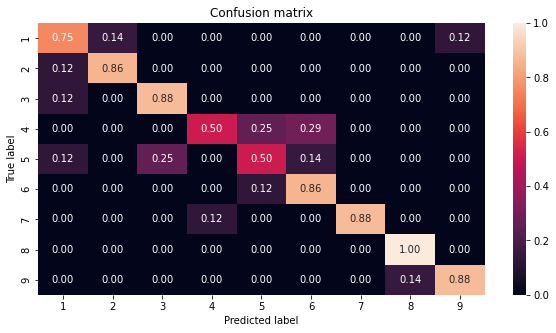

              precision    recall  f1-score   support

           1       0.67      0.75      0.71         8
           2       0.86      0.86      0.86         7
           3       0.78      0.88      0.82         8
           4       0.80      0.50      0.62         8
           5       0.57      0.50      0.53         8
           6       0.67      0.86      0.75         7
           7       1.00      0.88      0.93         8
           8       0.88      1.00      0.93         7
           9       0.88      0.88      0.88         8

    accuracy                           0.78        69
   macro avg       0.79      0.79      0.78        69
weighted avg       0.79      0.78      0.78        69



,0,1,2,3,4,5,6,7,8,9,...,831,832,833,834,835,836,837,838,839,840
1,27648.0,0.0,-2.033113,1.441493,-1.109995,0.896706,-0.747040,0.635516,-0.548640,0.478594,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,20992.0,0.0,12.022733,-8.524210,6.563908,-5.302636,4.417592,-3.758101,3.244363,-2.830147,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,32768.0,0.0,0.721451,-0.511514,0.393882,-0.318196,0.265087,-0.225513,0.194685,-0.169829,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,32256.0,0.0,1.305784,-0.925811,0.712903,-0.575917,0.479793,-0.408166,0.352369,-0.307381,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,33792.0,0.0,-1.086656,0.770447,-0.593269,0.479270,-0.399277,0.339670,-0.293237,0.255798,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,49152.0,0.0,26.750094,-18.966021,14.604428,-11.798149,9.828962,-8.361622,7.218575,-6.296962,...,42.42206,-32.666311,26.389395,-21.984835,18.702775,-16.146077,14.084668,-12.375977,10.926878,-9.673898
9,34304.0,0.0,19.740113,-13.995891,10.777273,-8.706392,7.253239,-6.170422,5.326915,-4.646815,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,34304.0,0.0,19.151660,-13.578673,10.456002,-8.446854,7.037020,-5.986481,5.168120,-4.508294,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,40960.0,0.0,-21.626092,15.333064,-11.806938,9.538204,-7.946217,6.759947,-5.835851,5.090774,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
import seaborn as sns

"""

    TP = True positive   FP = False positive
    TF = True negative   FN = False negative

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1-score = (2*recall*precision)/(recall+precision)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    
"""
# Normalize confusion matrix
cms = cms / cms.sum(axis=1)

plt.subplots(figsize=(10,5))
sns.heatmap(cms, annot=True,
           fmt=".2f",
           xticklabels = labels,
           yticklabels = labels)

plt.title("Confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
#plt.savefig("CM", dpi = 1200)
plt.show()

print(clrs[-1])
display(dataset)

In [ ]:
# This sample is from someone whose voice was used to train the model
filename = "viisi_t"
audio_sample = read_wav(f"./predict/{filename}.wav")

prediction = predict_input(filename,model,scaler, X_train.shape[1])
print(f"The number you said was {prediction}")

Audio(audio_sample, rate=fs)

The number you said was 6


/tmp/ipykernel_1738/327516794.py:84: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(path)
/tmp/ipykernel_1738/327516794.py:95: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, test_sample = wavfile.read(f"./predict/{audioname}.wav")


In [8]:
# This sample is from someone whose voice was used to train the model

filename = "test7"
audio_sample = read_wav(f"./predict/{filename}.wav")

prediction = predict_input(filename,model,scaler, X_train.shape[1])
print(f"The number you said was {prediction}")

Audio(audio_sample, rate=fs)

ERROR! Session/line number was not unique in database. History logging moved to new session 16
The number you said was 5


In [9]:
# This sample is from someone whose voice was used to train the model

filename = "kolme_t"
audio_sample = read_wav(f"./predict/{filename}.wav")

prediction = predict_input(filename,model,scaler, X_train.shape[1])
print(f"The number you said was {prediction}")

Audio(audio_sample, rate=fs)

The number you said was 3


/tmp/ipykernel_1738/327516794.py:84: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wavfile.read(path)
/tmp/ipykernel_1738/327516794.py:95: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, test_sample = wavfile.read(f"./predict/{audioname}.wav")
